<a href="https://colab.research.google.com/github/nikhils10/Multivariate-Analysis--Oil-Price-Prediction-Using-LSTM-GRU-/blob/master/Multivariate_Oil_Price_Prediction_Using_LSTM_%26_GRU_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project Title : Multivariate Analysis & Stock Price Prediction Using  LSTM**

**Problem Type** : Multivariate Forecasting

**Actionable Decision :** Whether to Invest or Not in the Commodity 

Importing and installing libraries

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
#import plotly.express as px
from scipy.stats import zscore as zs
from scipy import linalg as scipy_linalg
from sklearn.model_selection import train_test_split as split
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, GRU
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(1)
# from google.colab import files
from tensorflow.keras.optimizers import SGD
from IPython.display import display, Image


In [24]:
##Matplotlib Parameters
import matplotlib.ticker as ticker
from pylab import rcParams
rcParams['axes.labelsize'] = 12
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
plt.style.context('fivethirtyeight')

Loading Data

In [59]:
from pandas_datareader import data as web
tickers = ['FNGU', '^DJI', 'SPY', '^TNX', 'UCO', '^VIX']
df = web.DataReader(tickers, data_source='yahoo', start='2020-01-01', end='2022-12-31')[Open]

NameError: name 'Open' is not defined

In [62]:
df['Open']

Symbols,FNGU,^DJI,SPY,^TNX,UCO,^VIX
Date,,,,,,
2020-01-02,6.212000,28638.970703,323.540009,1.903,510.750000,13.460000
2020-01-03,6.300000,28553.330078,321.160004,1.828,548.000000,15.010000
2020-01-06,6.139000,28465.500000,320.489990,1.785,551.750000,15.450000
2020-01-07,6.680000,28639.179688,323.019989,1.797,535.750000,13.840000
2020-01-08,6.731000,28556.140625,322.940002,1.823,532.500000,15.160000
...,...,...,...,...,...,...
2022-03-15,13.350000,32989.269531,419.769989,2.119,135.509995,33.130001
2022-03-16,16.000000,33653.929688,429.890015,2.169,140.800003,29.020000
2022-03-17,18.020000,33995.390625,433.589996,2.142,145.750000,26.510000


# Exploratory Data Analysis(EDA)

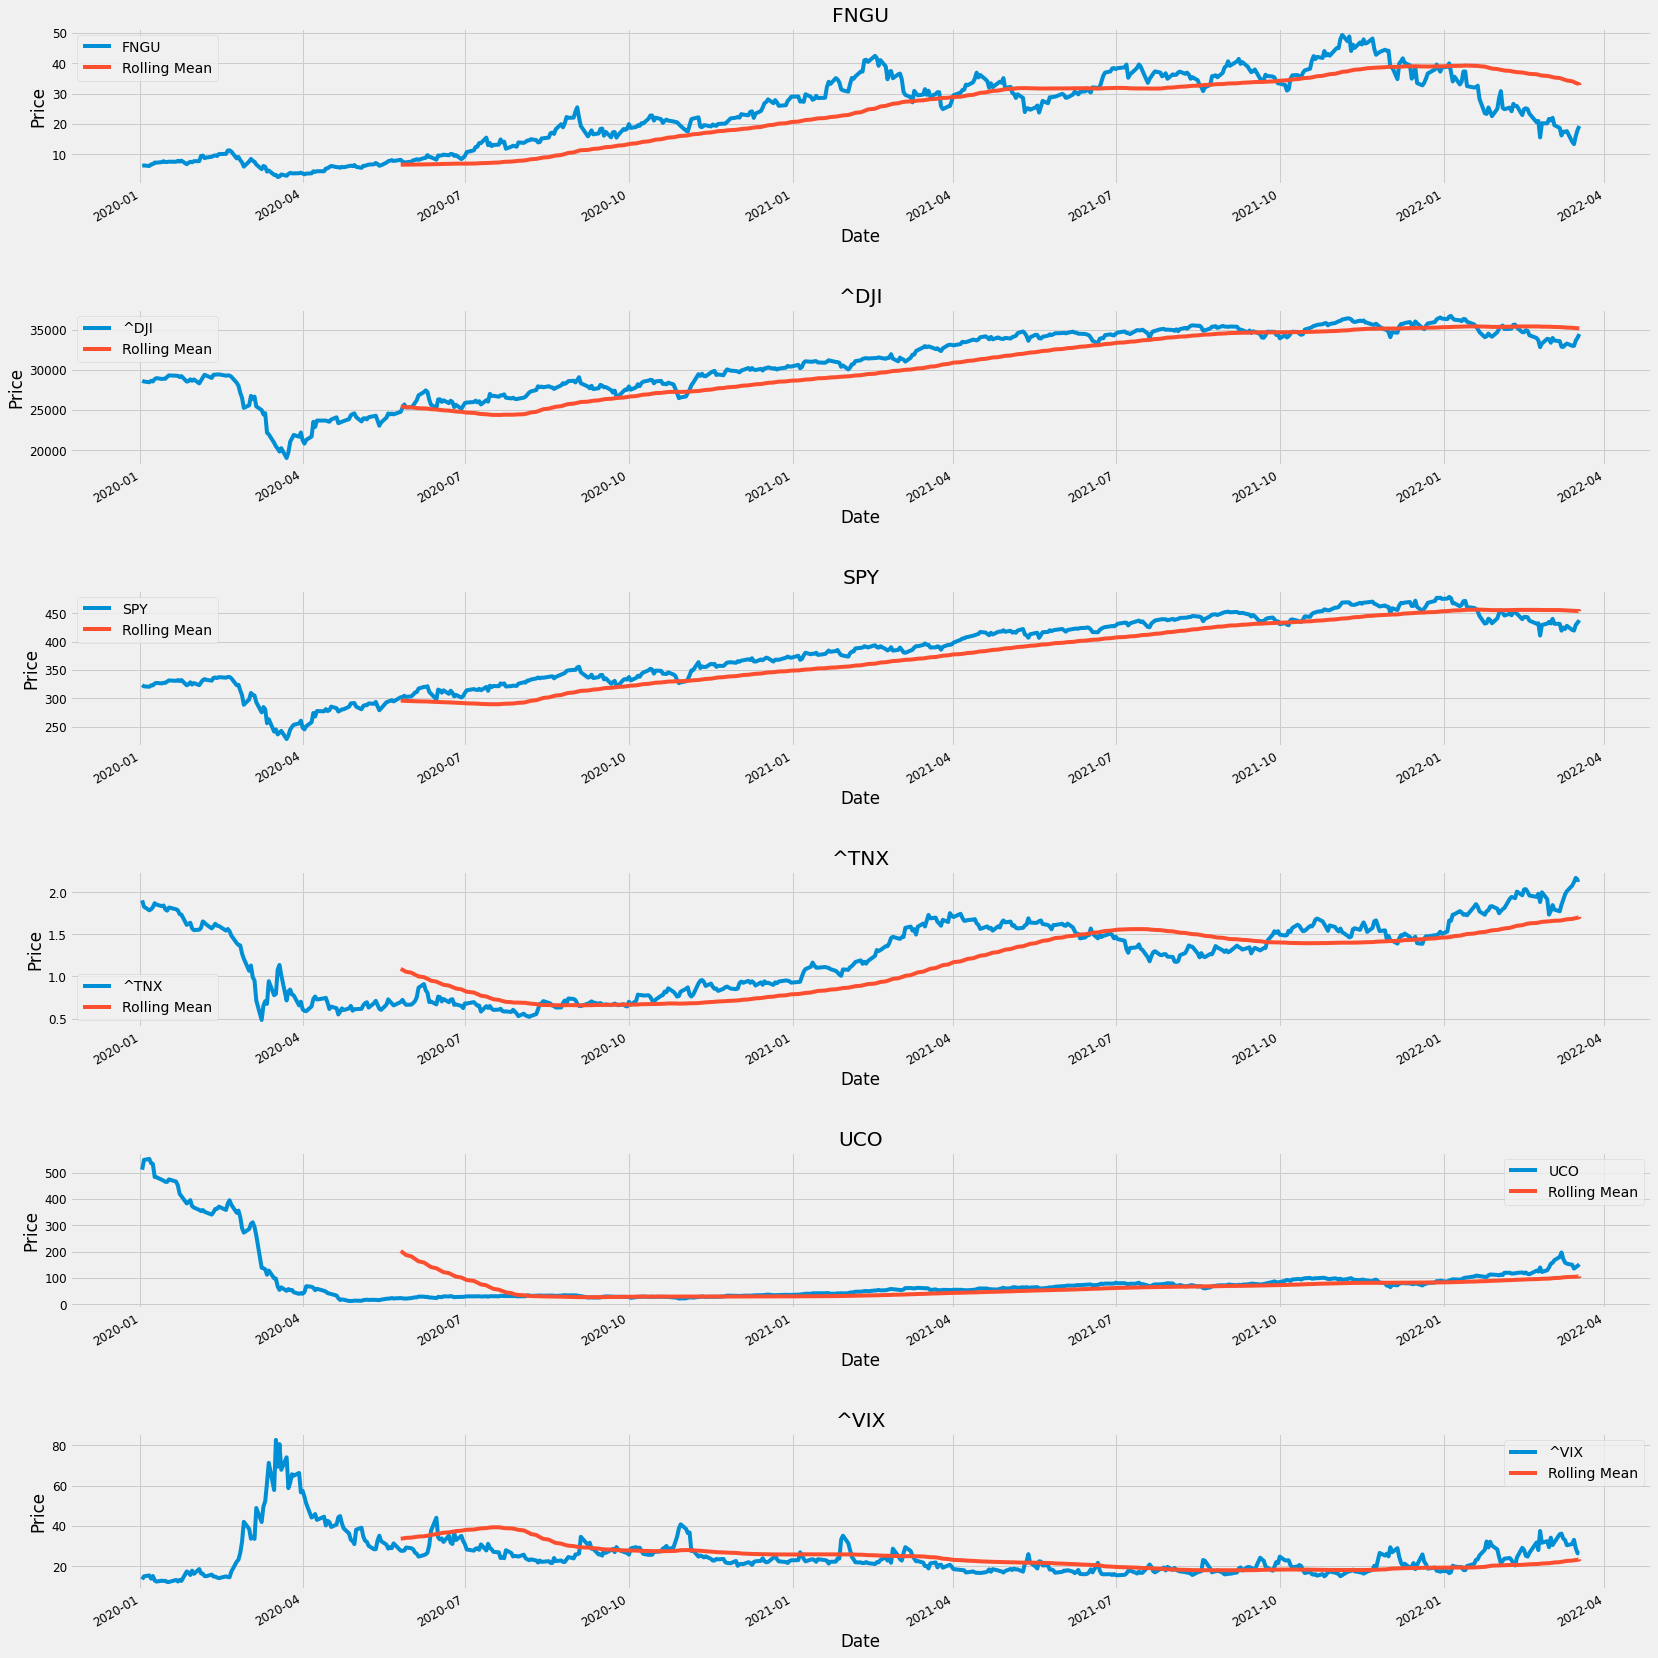

In [63]:
##Line Plots Target & Features
data = df['Open']
col_names = data.columns

fig = plt.figure(figsize=(24, 24))
plt.style.use('fivethirtyeight')
for i in range(6):
  ax = fig.add_subplot(6,1,i+1)
  ax.plot(data.iloc[:,i],label=col_names[i])
  data.iloc[:,i].rolling(100).mean().plot(label='Rolling Mean')
  ax.set_title(col_names[i])
  ax.set_xlabel('Date')
  ax.set_ylabel('Price')
  plt.legend()
fig.tight_layout(pad=3.0)
plt.show()

Inferences :-

-> WTI has mix of both UP and DOWN trends.

-> Gold, DJU has UP Trend.

-> US Dollar Index, US 10YR Bond has downward trend.


C:\Users\ykchi\miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ykchi\miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ykchi\miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-

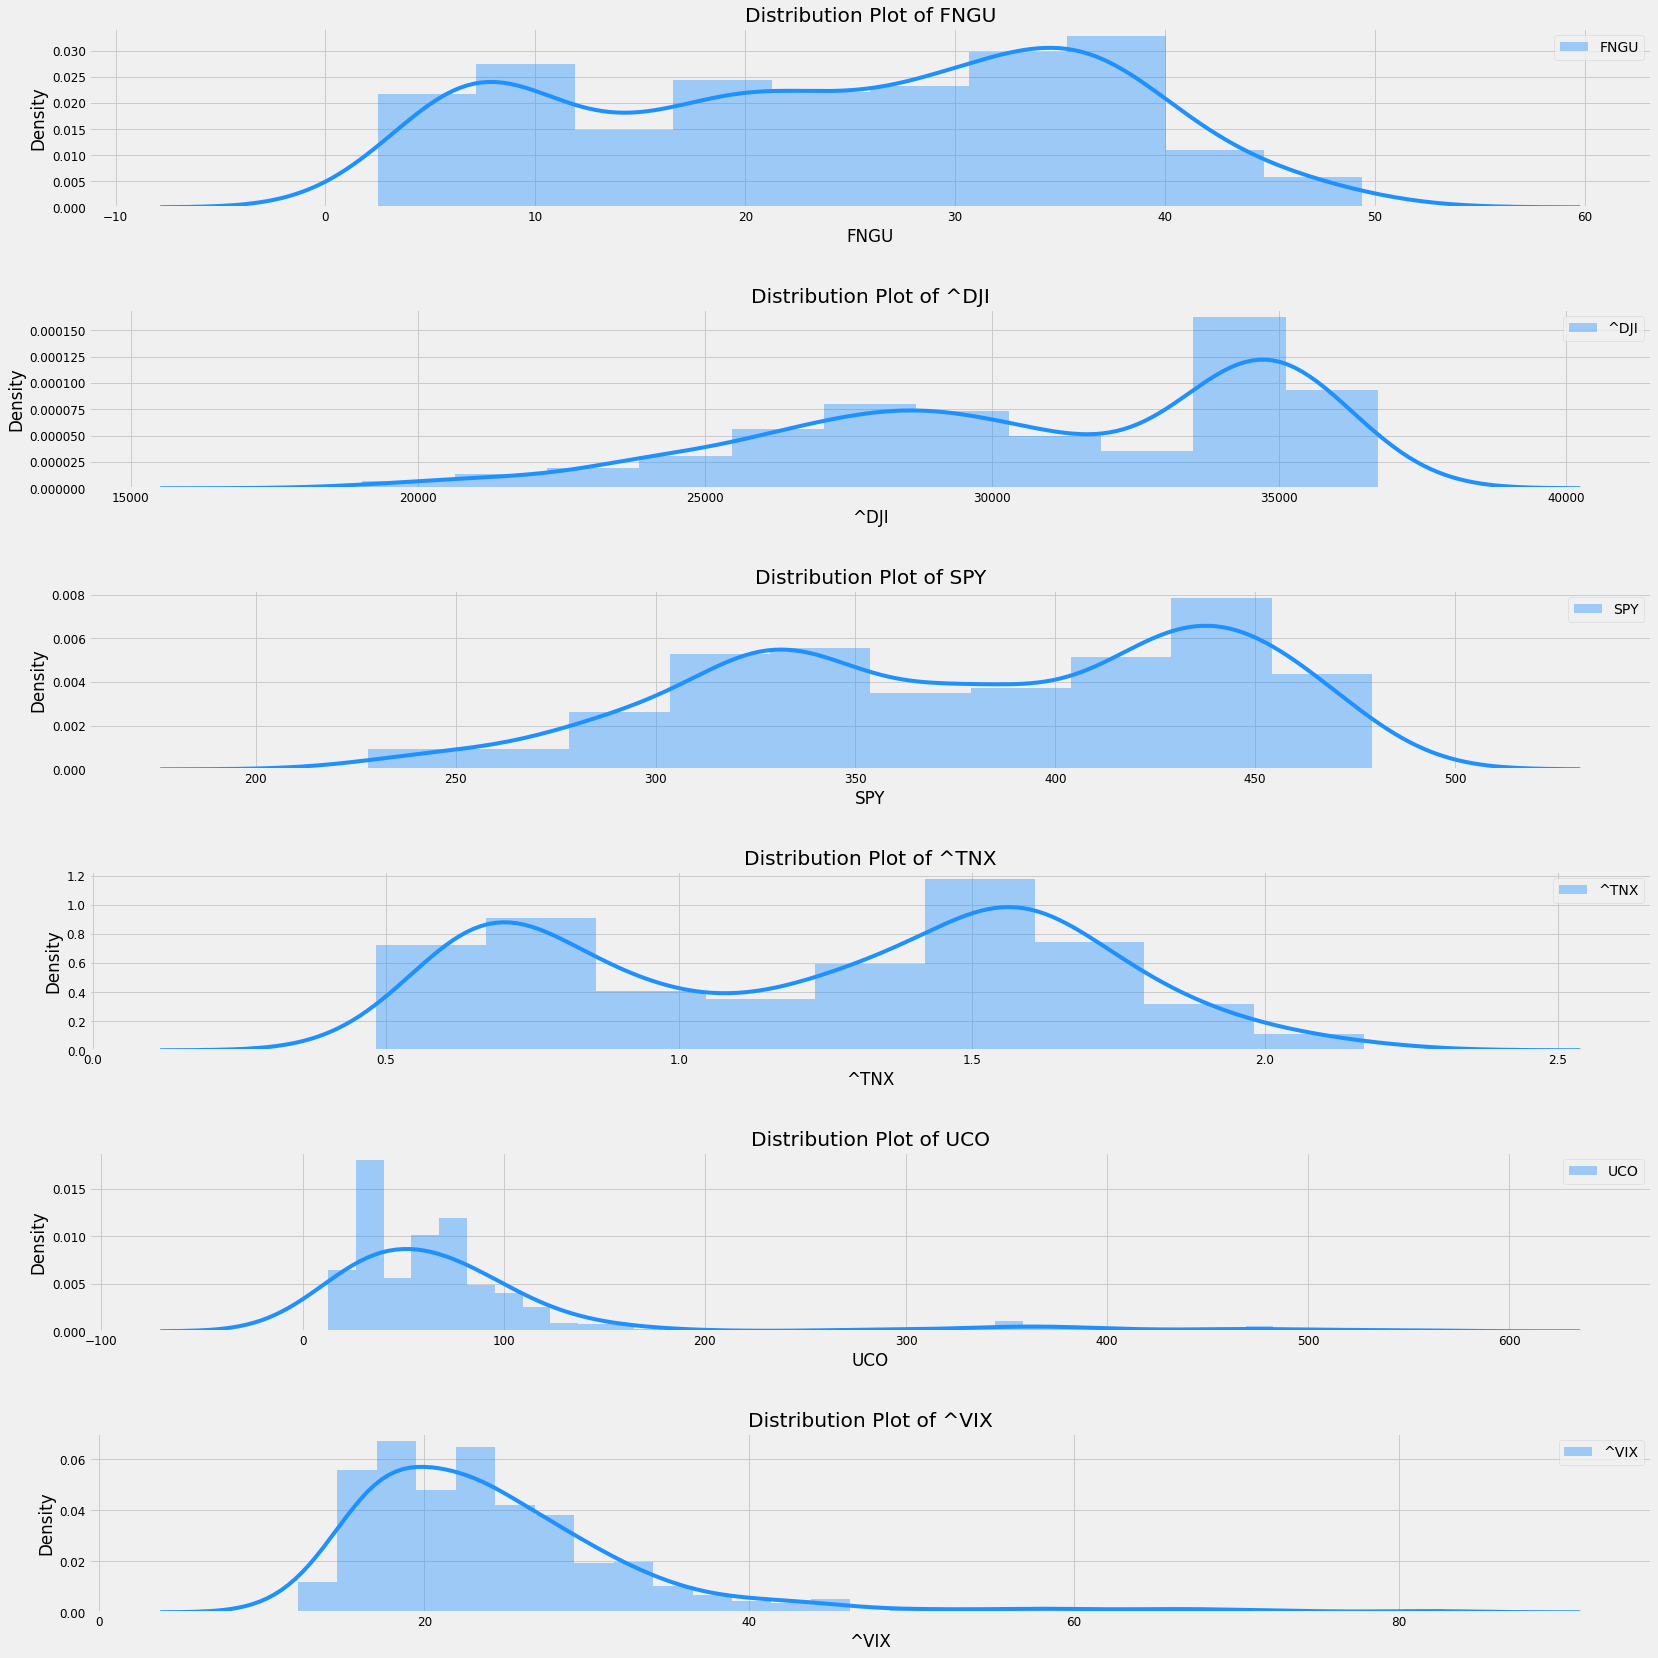

In [64]:
##Checking if Target and Features follow Normal Distribution
data = df['Open']
fig = plt.figure(figsize=(24, 24))
plt.style.use('fivethirtyeight')
col_names = data.columns
for i in range(6):
  ax = fig.add_subplot(6,1,i+1)
  sns.distplot(data.iloc[:,i],label=col_names[i],color='dodgerblue').set_title("Distribution Plot of {}".format(col_names[i]),axes=ax)
  ax.tick_params(labelsize=12)
  plt.legend()
fig.tight_layout(pad=3.0)
plt.show()


From above Distribution plots :-

-> Most frequent values of WTI are in the range of 25 to 35.

-> The WTI oil price values above 120
are less frequent.

-> All Features & WTI don't follow Normal Distribution.

In [65]:
## Temporary DataFrame
temp_data = df['Open']
temp_data['Year'] = df.index.year

<ipython-input-65-3493d34f73ef>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_data['Year'] = df.index.year


-> The above Lag plot indicates that WTI has good positive correlation with each of its lagging orders.

-> This kind of series is good for time series as its showing auto-regressive nature.

**Bivariate Analysis (WTI and Features)**

In [67]:
##Scaling Data to Observe Bivariate Analysis 
sc = MinMaxScaler(feature_range=(0,1))
oil_df_scaled= sc.fit_transform(df['Open'])

Since distribution is not normal we use Standardisation instead of Normalization.

In [68]:
##Scaled Data Glimse
oil_df_scaled[:2]

array([[0.07912748, 0.54314908, 0.37983511, 0.84213654, 0.92394591,
        0.01787488],
       [0.08100386, 0.53830905, 0.37035415, 0.79762613, 0.99304383,
        0.03986381]])

ValueError: x and y must have same first dimension, but have shapes (4947,) and (559,)

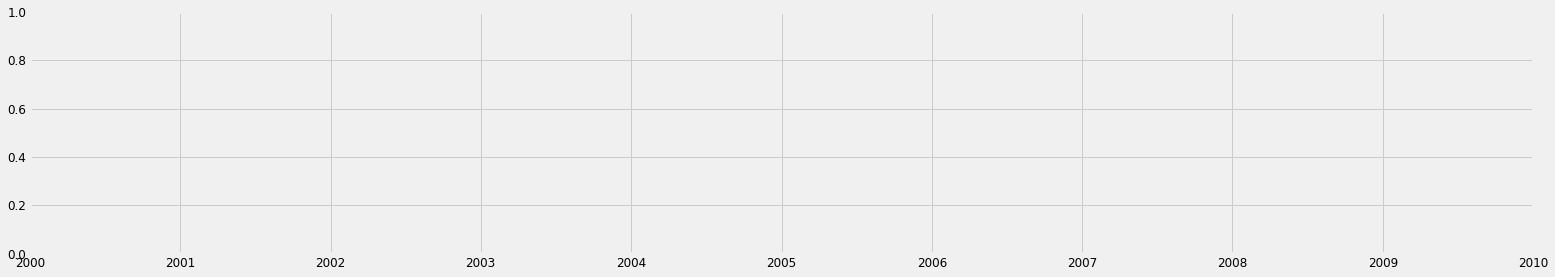

In [69]:
##Comparing Movement of WTI wrt to Features
col_names = data.columns[1:]
scaled_features = oil_df_scaled[:,1:]
fig = plt.figure(figsize=(24, 24))
plt.style.use('fivethirtyeight')
for i in range(5):
  ax = fig.add_subplot(5,1,i+1)
  ax.plot(oil_df.index,scaled_features[:,i],label=col_names[i],c='red')
  ax.plot(oil_df.index,oil_df_scaled[:,0],label='FNGU',c='grey')
  ax.set_title('FNGU  & ' + col_names[i])
  ax.set_xlabel('Date')
  ax.set_ylabel('Price')
  plt.legend()
fig.tight_layout(pad=3.0)
plt.show()

Inferences From Bivariate Feature Analysis :-

->During 2009 the value for both WTI and SP 500 drop sharply indicating that both these series are affected by same external factors. Move together.


->US Dollar index coinciding at several points
with WTI, meaning that both the variables are strongly correlated. Apart from some common
points the relationship seems to be inverse specifically when observing periods of 2000, 2007-
09 and 2010-16. Don't Move together.


->Both WTI and gold are fluctuating together.
The gold seems to be lagging to the WTI in some ways especially if we observe years 2007
wherein gold has not had much difference as WTI. Move together.

->US 10 year bond interest rates seem
to be a leading indicator to volatility of WTI price, as we can see specifically from 2000-09 US
bond progresses downward and then the WTI follows it. The US interest rate basically gave us
a leading indication to financial crisis is what we have observed. Don't Move together.

-> DJU & WTI move together.Very High correlation between 2003-2009.


**Multivariate Analysis**

In [70]:
#fig = px.parallel_coordinates(oil_df,color='WTI',color_continuous_scale=px.colors.diverging.Tealrose,
                              title='Parallel Co-ordinates Plot')

#fig.show()

IndentationError: unexpected indent (<ipython-input-70-ac81a1bdd68a>, line 2)

In [71]:
##To display on Github Viewer
#display(Image(filename='/content/drive/My Drive/GitHub Projects/LSTM Oil Price/parallel plots img.png'))

Inferences From Parallel Co-ordinates Plot :-

->The higher values of WTI correpond to average values for GOLD,US 10 YR BOND,DJU. (Red shaded Path)

->Low Values of WTI correspond to High Values of US Dollar Index(Dark Green Shaded Path).


Since Target & Feature don't follow normal distribution , we will use
**Spearman Correlation**.


**HeatMap**

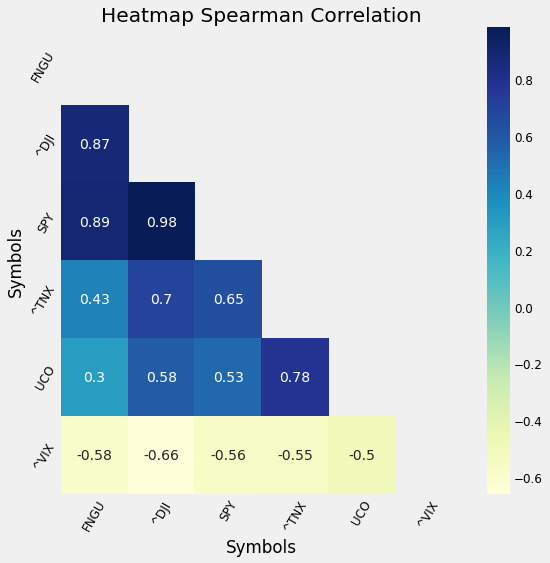

In [73]:
##HeatMap Spearman Correlation
plt.figure(figsize=(8,8))
matrix = np.triu(df['Open'].corr(method='spearman'))
heat_map = sns.heatmap(df['Open'].corr(method='spearman'),annot=True,annot_kws={"size":14},cmap= 'YlGnBu',mask=matrix)
heat_map.set_yticklabels(heat_map.get_yticklabels(), rotation=60)
heat_map.set_xticklabels(heat_map.get_xticklabels(), rotation=60)
plt.tick_params(labelsize=12)
plt.title('Heatmap Spearman Correlation')
plt.style.use('fivethirtyeight')

-> The highest positive correlation with target variable WTI is with Gold(ρ:0.72)

-> We also observe that SP500 and WTI have less correlation.(ρ : 0.23)

-> US 10 YR Bond and WTI are moderately inversely correlated.(ρ : -0.39) 

-> DJU & WTI positive moderate correlation.(ρ : 0.41 )

-> US Dollar Index & WTI have high correlation .(ρ : -0.86)

-> We observe high correlation between DJU & SP 500 (ρ : 0.91)
observed the SP 500 and DJU also have very high positive correlation.This is kind of Expected since both are indexes.


In [74]:
##Spearman Correlation In Tabular Form
df['Open'].corr(method='spearman')

Symbols,FNGU,^DJI,SPY,^TNX,UCO,^VIX
Symbols,,,,,,
FNGU,1.000000,0.874433,0.887570,0.430837,0.300929,-0.581839
^DJI,0.874433,1.000000,0.983326,0.695182,0.582080,-0.659065
SPY,0.887570,0.983326,1.000000,0.647734,0.528158,-0.562542
^TNX,0.430837,0.695182,0.647734,1.000000,0.783204,-0.549219
UCO,0.300929,0.582080,0.528158,0.783204,1.000000,-0.496657
^VIX,-0.581839,-0.659065,-0.562542,-0.549219,-0.496657,1.000000


# Feature Selection
We eliminate features by Filteration technique and use correlation factor .
->We eliminate all features having spearman correlation less than magnitude of 
0.4.  
->We remove SP 500 and US 10 YR Bond ,we also thereby eliminate Multicollinearity present among (SP 500 & DJU),(US 10 YR BOND & DJU),(GOLD & DJU).

Features remaining : WTI ,GOLD , US DOLLAR INDEX.
Since this is time series problem even WTI will be included as a feature as it is a autoregressive problem.

In [123]:
##Feature Selection
after_fs = df['Open'][['FNGU','UCO','^VIX']]
after_fs.head(3)

Symbols,FNGU,UCO,^VIX
Date,,,
2020-01-02,6.212,510.75,13.46
2020-01-03,6.300,548.00,15.01
2020-01-06,6.139,551.75,15.45


# **Outlier Elimination**

**(Method-1) Financial Crisis Outlier Removal (2007-2009)**

In [124]:
before_2007 = after_fs['2000-01':'2007-06']
after_2009 = after_fs['2009-06':'2019-06']
fin_out = pd.concat([before_2007,after_2009],axis=0)
fin_out.shape

(0, 3)

We observed financial crisis from 2007 to 2009.
We remove data points from mid of 2007 to mid of 2019 as this was a big crisis and led to lot of volatality of oil price movement as observed earlier.
We eliminated 482 outliers.

**(Method-2) Z-Score Outlier Removal Technique**

We can use Z-scores to detect outliers by calculating how many standard deviations away is a point from the mean.

In [125]:
zscore = np.abs(zs(after_fs['FNGU']))
zscore_df = after_fs.copy()
zscore_df['zscore'] = zscore
zscore_df.head(5)

Symbols,FNGU,UCO,^VIX,zscore
Date,,,,
2020-01-02,6.212,510.75,13.46,1.471512
2020-01-03,6.300,548.00,15.01,1.464326
2020-01-06,6.139,551.75,15.45,1.477474
2020-01-07,6.680,535.75,13.84,1.433293
2020-01-08,6.731,532.50,15.16,1.429128


In [126]:
##Considering Outliers of more than +-2.5 zscore as outliers
len(zscore_df[zscore_df['zscore']>2.5])

0

In [127]:
zscore_df = zscore_df.loc[zscore_df['zscore']<2.5,['FNGU','UCO','^VIX']]
zscore_df.shape

(559, 3)

We considered all points of more than 2.5 times away from mean as outliers and removed 37 datapoints.
Z-score can be calculated on univariate series so we used it on our target variable WTI and removed corresponding points.

**(Method-3) Mahalanobis Distance Outlier Removal Technique**

Mahalanobis distance is distance between two points in a multivariate space. It can be effectively used to eliminate outliers when :-

-> There is correlation with target variable.
 
-> Multi-dimensional distance is possible otherwise not possible in Euclidean distance. 

In [128]:
## Citing Source : https://www.machinelearningplus.com/statistics/mahalanobis-distance/
##Outlier Removal Method-3-Mahalanobis Distance
def mahalanobis(x=None, data=None, cov=None):
    """Compute the Mahalanobis Distance between each row of x and the data  
    x    : vector or matrix of data with, say, p columns.
    data : ndarray of the distribution from which Mahalanobis distance of each observation of x is to be computed.
    cov  : covariance matrix (p x p) of the distribution. If None, will be computed from data.
    """
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = scipy_linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()


In [129]:
mah_df = after_fs.copy()
mah_df['Mahalanobis'] = mahalanobis(x=mah_df, data=mah_df)
mah_df.head(3)

Symbols,FNGU,UCO,^VIX,Mahalanobis
Date,,,,
2020-01-02,6.212,510.75,13.46,18.945868
2020-01-03,6.300,548.00,15.01,21.933193
2020-01-06,6.139,551.75,15.45,22.276747


C:\Users\ykchi\miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Mahalanobis', ylabel='Density'>

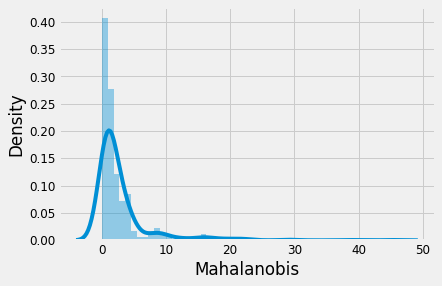

In [130]:
sns.distplot(mah_df['Mahalanobis'])

In [131]:
##We consider points with Mahalanobis distance greater than 8 to be outliers.
len(mah_df[mah_df['Mahalanobis']>8])

53

We removed 145 datapoints by using Mahalanobis distance.

# Data Preparation for Modelling 

**Train-Test Split**

In [132]:
z_train,z_test = split(zscore_df,train_size=0.7,shuffle=False) 

In [133]:
print('Zscore Dataset')
print(z_train.shape)
print(z_test.shape)

Zscore Dataset
(391, 3)
(168, 3)


**Scaling Data for Model**

In [134]:
##We need 2 scalers per model -Train and Test require different scalers
sc1 = MinMaxScaler(feature_range=(0,1))
sc2 = MinMaxScaler(feature_range=(0,1))

We will carry out Standardisation after train-test split to prevent overfitting.

LSTM /GRU stores data by taking in number of  timesteps for 1 output. So suppose we give 60 timesteps , that means for 61st day the model considers 1-60 days for sequence and so on.


In [135]:
##Function to Prepare Training Data for LSTM
def prepare_train_data_lstm(scaler,train_data,n_dim):
  input_data = scaler.fit_transform(train_data.values)
  print('Shape of Input Data Initially',input_data.shape)
  timesteps = 60
  global X1
  X1 = []
  global y1
  y1=[]
  for i in range(len(input_data)-timesteps-1):
    t=[]
    for j in range(0,timesteps):        
      
        t.append(input_data[[(i+j)], :])
    X1.append(t)
    y1.append(input_data[i+ timesteps,0])
  
  X1, y1= np.array(X1), np.array(y1)
  print('Shape of Train Part after transformation',X1.shape)
  print('Shape of Test Part after transformation ',y1.shape)
  
  X1 = X1.reshape(X1.shape[0],timesteps, n_dim)
  print('Final Shape ',X1.shape)
  return X1,y1

In [136]:
##LSTM Model Function
def lstm_model(scaler,train_data,n_dim):
    #initialize model
    prepare_train_data_lstm(scaler,train_data,n_dim)

    global model
    model = Sequential()

    #layer 1 of LSTM
    model.add(LSTM(units=30,return_sequences=True,input_shape=(X1.shape[1],n_dim)))
    model.add(Dropout(0.2))

    #layer 2 of LSTM
    model.add(LSTM(units=30,return_sequences=True))
    model.add(Dropout(0.2))

    #layer 3 of LSTM
    model.add(LSTM(units=30,return_sequences=True))
    model.add(Dropout(0.2))

    #layer 4 of LSTM
    model.add(LSTM(units=30))
    model.add(Dropout(0.2))

    #Output layer of model
    model.add(Dense(units=1))

    optimizer = tf.keras.optimizers.Adam(lr=2e-5)
    #compiling the model
    model.compile(optimizer=optimizer,loss='mean_squared_error')
    model.fit(X1, y1, epochs=50, batch_size=32)

In [137]:
##Function to Prepare Test Data
def prepare_test_data_lstm(scaler,test_data,n_dim):
  inputs = scaler.transform(test_data.values)
  global X_test
  X_test = []
  timesteps = 60
  for i in range(len(inputs)-timesteps-1):
      t=[]
      for j in range(0,timesteps):
        
          t.append(inputs[[(i+j)], :])
      X_test.append(t)
  X_test = np.array(X_test)
  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], n_dim))
  print('Shape of Test Dataset',X_test.shape)

In [138]:
##Function to Predict Data
def predict_data(model_name,scaler_pred,test_data,X_test,Outlier_method,n_dim):
  
  pred = model_name.predict(X_test)
  print(len(test_data[61:]))
  set_scale = scaler_pred.fit_transform(test_data.iloc[61:,0].values.reshape(-1,1))
  pred_descale = scaler_pred.inverse_transform(pred)
  global pred_df
  pred_df = pd.DataFrame(pred_descale,columns=['Predicted -'+str(Outlier_method)])
  return pred_df

In [139]:
##Function to Calculate Result Metrics
def result_metrics_forecast(test_series,forecast_series,model_name,out_name):
  print('Result Metrics for ' +  str(model_name) + ' -{} Outlier Removal Technique'.format(out_name))
  print('R2 Score : ',round(r2_score(test_series,forecast_series),3))
  print('Mean Squared Error : ',round(mean_squared_error(test_series,forecast_series),3))
  print('Mean Absolute Error : ',round(mean_absolute_error(test_series,forecast_series),3))
  fig = plt.figure(figsize=(10,10))
  plt.plot(test_series.index,test_series,label='Actual')
  plt.plot(test_series.index,forecast_series,label='Predicted')
  plt.title(str(model_name) + ' -Forecasting Using {} Outlier Removal Technique'.format(out_name))
  plt.ylabel('Price')
  plt.legend()

In [140]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor = 'loss',patience = 20)
X1,y1 = prepare_train_data_lstm(sc1,z_train,3)

Shape of Input Data Initially (391, 3)
Shape of Train Part after transformation (330, 60, 1, 3)
Shape of Test Part after transformation  (330,)
Final Shape  (330, 60, 3)


In [141]:
""" 
About this model : -
3 Layers of LSTM 
1 Hidden Layer
Output Layer- learning rate is being optimized 
Optimizer function is Adam
""" 
import tensorflow as tf

## 4 layers of LSTM Model
model_simple = Sequential()
 
#layer 1 of LSTM
model_simple.add(LSTM(units=64,return_sequences=True,input_shape=(X1.shape[1],3)))
model_simple.add(Dropout(0.2))

#layer 2 of LSTM
model_simple.add(LSTM(units=32,return_sequences=True,input_shape=(X1.shape[1],3)))
model_simple.add(Dropout(0.2))

#layer 3 of LSTM
model_simple.add(LSTM(units=32,return_sequences=True,input_shape=(X1.shape[1],3)))
model_simple.add(Dropout(0.2))

#layer 4 of LSTM
model_simple.add(LSTM(units=16,input_shape=(X1.shape[1],3)))
model_simple.add(Dropout(0.2))

##Hidden Layer 
model_simple.add(Dense(units=16))
#Output layer of model
model_simple.add(Dense(units=1))


#compiling the model
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 10))
optimizer = tf.keras.optimizers.Adam(lr=1e-8)
model_simple.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])

##Model Fit
history_simple = model_simple.fit(X1, y1, epochs=200, batch_size=32,callbacks=[lr_schedule],validation_split=0.3,shuffle=False)

C:\Users\ykchi\miniconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/200
8/8 [==============================] - 25s 593ms/step - loss: 0.0907 - mae: 0.3556 - val_loss: 0.2405 - val_mae: 0.6862 - lr: 1.0000e-08
Epoch 2/200
8/8 [==============================] - 1s 116ms/step - loss: 0.0908 - mae: 0.3564 - val_loss: 0.2405 - val_mae: 0.6862 - lr: 1.2589e-08
Epoch 3/200
8/8 [==============================] - 1s 115ms/step - loss: 0.0911 - mae: 0.3570 - val_loss: 0.2405 - val_mae: 0.6861 - lr: 1.5849e-08
Epoch 4/200
8/8 [==============================] - 1s 120ms/step - loss: 0.0917 - mae: 0.3582 - val_loss: 0.2405 - val_mae: 0.6861 - lr: 1.9953e-08
Epoch 5/200
8/8 [==============================] - 1s 117ms/step - loss: 0.0908 - mae: 0.3560 - val_loss: 0.2405 - val_mae: 0.6861 - lr: 2.5119e-08
Epoch 6/200
8/8 [==============================] - 1s 106ms/step - loss: 0.0897 - mae: 0.3544 - val_loss: 0.2404 - val_mae: 0.6861 - lr: 3.1623e-08
Epoch 7/200
8/8 [==============================] - 1s 106ms/step - loss: 0.0906 - mae: 0.3564 - val_loss: 0.240

8/8 [==============================] - 1s 107ms/step - loss: 0.0071 - mae: 0.0864 - val_loss: 0.0167 - val_mae: 0.1505 - lr: 0.0032
Epoch 57/200
8/8 [==============================] - 1s 104ms/step - loss: 0.0218 - mae: 0.1813 - val_loss: 0.0233 - val_mae: 0.1764 - lr: 0.0040
Epoch 58/200
8/8 [==============================] - 1s 103ms/step - loss: 0.0373 - mae: 0.2226 - val_loss: 0.0098 - val_mae: 0.1174 - lr: 0.0050
Epoch 59/200
8/8 [==============================] - 1s 104ms/step - loss: 0.0212 - mae: 0.1527 - val_loss: 0.0080 - val_mae: 0.1062 - lr: 0.0063
Epoch 60/200
8/8 [==============================] - 1s 102ms/step - loss: 0.0109 - mae: 0.1010 - val_loss: 0.0099 - val_mae: 0.1229 - lr: 0.0079
Epoch 61/200
8/8 [==============================] - 1s 104ms/step - loss: 0.0088 - mae: 0.1088 - val_loss: 0.0125 - val_mae: 0.1243 - lr: 0.0100
Epoch 62/200
8/8 [==============================] - 1s 103ms/step - loss: 0.0290 - mae: 0.2012 - val_loss: 0.0118 - val_mae: 0.1312 - lr: 0.012

Epoch 110/200
8/8 [==============================] - 1s 105ms/step - loss: 21164402.0000 - mae: 21164402.0000 - val_loss: 54522548.0000 - val_mae: 54522548.0000 - lr: 794.3282
Epoch 111/200
8/8 [==============================] - 1s 104ms/step - loss: 57067440.0000 - mae: 57067440.0000 - val_loss: 37063084.0000 - val_mae: 37063084.0000 - lr: 1000.0000
Epoch 112/200
8/8 [==============================] - 1s 110ms/step - loss: 70497304.0000 - mae: 70497304.0000 - val_loss: 109906000.0000 - val_mae: 109906000.0000 - lr: 1258.9254
Epoch 113/200
8/8 [==============================] - 1s 105ms/step - loss: 112731800.0000 - mae: 112731800.0000 - val_loss: 127792536.0000 - val_mae: 127792536.0000 - lr: 1584.8932
Epoch 114/200
8/8 [==============================] - 1s 105ms/step - loss: 218539152.0000 - mae: 218539152.0000 - val_loss: 656546496.0000 - val_mae: 656546496.0000 - lr: 1995.2623
Epoch 115/200
8/8 [==============================] - 1s 105ms/step - loss: 204359200.0000 - mae: 204359200

8/8 [==============================] - 1s 116ms/step - loss: 2027554873540608.0000 - mae: 2027554873540608.0000 - val_loss: 656943030992896.0000 - val_mae: 656943030992896.0000 - lr: 12589254.0000
Epoch 153/200
8/8 [==============================] - 1s 112ms/step - loss: 1918501493145600.0000 - mae: 1918501493145600.0000 - val_loss: 4404608952696832.0000 - val_mae: 4404608952696832.0000 - lr: 15848932.0000
Epoch 154/200
8/8 [==============================] - 1s 113ms/step - loss: 6044777774579712.0000 - mae: 6044777774579712.0000 - val_loss: 5164916143030272.0000 - val_mae: 5164916143030272.0000 - lr: 19952624.0000
Epoch 155/200
8/8 [==============================] - 1s 106ms/step - loss: 12368159340232704.0000 - mae: 12368159340232704.0000 - val_loss: 17460625827430400.0000 - val_mae: 17460625827430400.0000 - lr: 25118864.0000
Epoch 156/200
8/8 [==============================] - 1s 112ms/step - loss: 11101474700394496.0000 - mae: 11101474700394496.0000 - val_loss: 14193001823731712.00

Epoch 188/200
8/8 [==============================] - 1s 105ms/step - loss: 18806292327660395692032.0000 - mae: 18806292327660395692032.0000 - val_loss: 870049567586775990272.0000 - val_mae: 870049567586775990272.0000 - lr: 50118721536.0000
Epoch 189/200
8/8 [==============================] - 1s 104ms/step - loss: 13034100742853668896768.0000 - mae: 13034100742853668896768.0000 - val_loss: 19312414735083639930880.0000 - val_mae: 19312414735083639930880.0000 - lr: 63095734272.0000
Epoch 190/200
8/8 [==============================] - 1s 105ms/step - loss: 18266636117411750739968.0000 - mae: 18266636117411750739968.0000 - val_loss: 17415666331121306566656.0000 - val_mae: 17415666331121306566656.0000 - lr: 79432826880.0000
Epoch 191/200
8/8 [==============================] - 1s 105ms/step - loss: 19341435931082415407104.0000 - mae: 19341435931082415407104.0000 - val_loss: 3326716157996270878720.0000 - val_mae: 3326716157996270878720.0000 - lr: 99999997952.0000
Epoch 192/200
8/8 [===========

Text(0.5, 1.0, 'Learning Rate vs Loss')

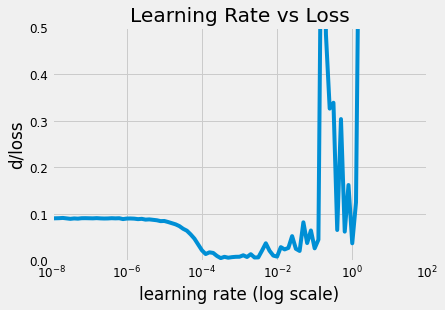

In [142]:
plt.semilogx(history_simple.history["lr"], history_simple.history["loss"])
plt.axis([1e-8, 100, 0, 60])
plt.ylim(0,0.5)
plt.ylabel("d/loss")
plt.xlabel("learning rate (log scale)")
plt.title('Learning Rate vs Loss')

(1e-05, 100)

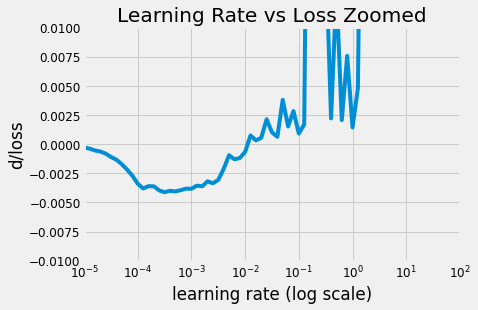

In [143]:
sma=20
n_skip=20
y_lim=(-0.01,0.01)
"""
Plots rate of change of the loss function.
    Parameters:
        sched - learning rate scheduler, an instance of LR_Finder class.
        sma - number of batches for simple moving average to smooth out the curve.
        n_skip - number of batches to skip on the left.
        y_lim - limits for the y axis.
    """
derivatives = [0] * (sma + 1)
for i in range(1 + sma,200):
  derivative = (history_simple.history["loss"][i] - history_simple.history["loss"][i - sma]) / sma
  derivatives.append(derivative)
        
plt.ylabel("d/loss")
plt.xlabel("learning rate (log scale)")
plt.title('Learning Rate vs Loss Zoomed')
plt.plot(history_simple.history["lr"][20:], derivatives[20:])
plt.xscale('log')
plt.ylim(y_lim)
plt.xlim(1e-5,100)

Zooming in into learning rate vs Epoch graph and finind optimal learning rate for our model.

**We take the learning rate where the loss is the minimum.
The optimal learning rate looks to be around 2e-5.**

Tuning learning rate is the most important parameter .

In [144]:
##8e-4 is the optimal learning rate.
## 4 layers of LSTM Model
model_simple = Sequential()
#layer 1 of LSTM
model_simple.add(LSTM(units=64,return_sequences=True,input_shape=(X1.shape[1],3)))
model_simple.add(Dropout(0.2))

#layer 2 of LSTM
model_simple.add(LSTM(units=32,return_sequences=True,input_shape=(X1.shape[1],3)))
model_simple.add(Dropout(0.2))

#layer 3 of LSTM
model_simple.add(LSTM(units=32,return_sequences=True,input_shape=(X1.shape[1],3)))
model_simple.add(Dropout(0.2))

#layer 4 of LSTM
model_simple.add(LSTM(units=16,input_shape=(X1.shape[1],3)))
model_simple.add(Dropout(0.2))

##Hidden Layer 
model_simple.add(Dense(units=16))
#Output layer of model
model_simple.add(Dense(units=1))

#compiling the model

optimizer = tf.keras.optimizers.Adam(lr=2e-5)
model_simple.compile(loss=tf.keras.losses.MSE,
              optimizer=optimizer)

history_simple = model_simple.fit(X1, y1, epochs=40, batch_size=32,validation_split=0.3,shuffle=False)

Epoch 1/40
8/8 [==============================] - 17s 421ms/step - loss: 0.2101 - val_loss: 0.5428
Epoch 2/40
8/8 [==============================] - 1s 108ms/step - loss: 0.2072 - val_loss: 0.5354
Epoch 3/40
8/8 [==============================] - 1s 111ms/step - loss: 0.2025 - val_loss: 0.5281
Epoch 4/40
8/8 [==============================] - 1s 111ms/step - loss: 0.2002 - val_loss: 0.5209
Epoch 5/40
8/8 [==============================] - 1s 109ms/step - loss: 0.1960 - val_loss: 0.5136
Epoch 6/40
8/8 [==============================] - 1s 110ms/step - loss: 0.1927 - val_loss: 0.5062
Epoch 7/40
8/8 [==============================] - 1s 110ms/step - loss: 0.1910 - val_loss: 0.4987
Epoch 8/40
8/8 [==============================] - 1s 108ms/step - loss: 0.1850 - val_loss: 0.4911
Epoch 9/40
8/8 [==============================] - 1s 109ms/step - loss: 0.1836 - val_loss: 0.4832
Epoch 10/40
8/8 [==============================] - 1s 108ms/step - loss: 0.1799 - val_loss: 0.4751
Epoch 11/40
8/8 [=

<Figure size 432x288 with 0 Axes>

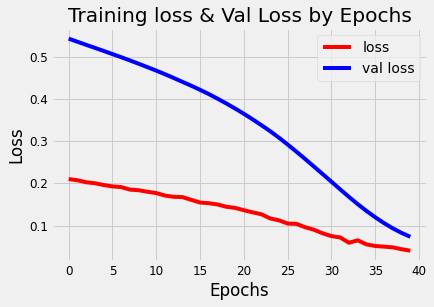

<Figure size 432x288 with 0 Axes>

In [145]:
loss=history_simple.history['loss']
val_loss = history_simple.history['val_loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r',label='loss')
plt.plot(epochs,val_loss,'blue',label='val loss')
plt.title('Training loss & Val Loss by Epochs')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.figure()

Since both training loss and validation loss are close to each other there seems to be no overfitting .
We notice smooth loss curves which is a good sign .
If there was a lot of jagginess or validation loss decreasing with increasing number of epochs we would be looking at overfitting .
In this case there appears to be no overfitting . 

# Forecasting Using LSTM(Long Term Short Memory)
LSTM are type of Re-current Neural Network with 3 gates (input,output & forget).

In [146]:
##Forecasting For Z-Score Outlier Removed Dataset 
lstm_model(sc1,z_train,3)

Shape of Input Data Initially (391, 3)
Shape of Train Part after transformation (330, 60, 1, 3)
Shape of Test Part after transformation  (330,)
Final Shape  (330, 60, 3)


C:\Users\ykchi\miniconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/50
11/11 [==============================] - 15s 90ms/step - loss: 0.2534
Epoch 2/50
11/11 [==============================] - 1s 86ms/step - loss: 0.2348
Epoch 3/50
11/11 [==============================] - 1s 84ms/step - loss: 0.2222
Epoch 4/50
11/11 [==============================] - 1s 85ms/step - loss: 0.2061
Epoch 5/50
11/11 [==============================] - 1s 84ms/step - loss: 0.1970: 0s - lo
Epoch 6/50
11/11 [==============================] - 1s 84ms/step - loss: 0.1777
Epoch 7/50
11/11 [==============================] - 1s 84ms/step - loss: 0.1628
Epoch 8/50
11/11 [==============================] - 1s 84ms/step - loss: 0.1542
Epoch 9/50
11/11 [==============================] - 1s 85ms/step - loss: 0.1386
Epoch 10/50
11/11 [==============================] - 1s 84ms/step - loss: 0.1236
Epoch 11/50
11/11 [==============================] - 1s 84ms/step - loss: 0.1192
Epoch 12/50
11/11 [==============================] - 1s 82ms/step - loss: 0.1066
Epoch 13/50
11/11 [========

Shape of Input Data Initially (3125, 3)
Shape of Train Part after transformation (3064, 60, 1, 3)
Shape of Test Part after transformation  (3064,)
Final Shape  (3064, 60, 3)

Epoch 1/50
96/96 [==============================] - 1s 15ms/step - loss: 0.0272

Epoch 2/50
96/96 [==============================] - 1s 14ms/step - loss: 0.0064

Epoch 3/50
96/96 [==============================] - 1s 12ms/step - loss: 0.0058

Epoch 4/50
96/96 [==============================] - 1s 13ms/step - loss: 0.0050


In [147]:
prepare_test_data_lstm(sc1,z_test,3)

Shape of Test Dataset (107, 60, 3)


In [148]:
predict_data(model,sc2,z_test,X_test,'Z-Score Outlier',3)

107


,Predicted -Z-Score Outlier
0,42.273178
1,42.216911
2,42.162907
3,42.114025
4,42.073269
...,...
102,35.540974
103,35.263081
104,34.976395
105,34.685955


In [149]:
z_out_pred = pred_df.copy()
z_out_actual = z_test.iloc[61:,0].copy()

Result Metrics for FNGU-LSTM -ZScore Outlier Removal Technique
R2 Score :  -0.39
Mean Squared Error :  141.701
Mean Absolute Error :  9.828


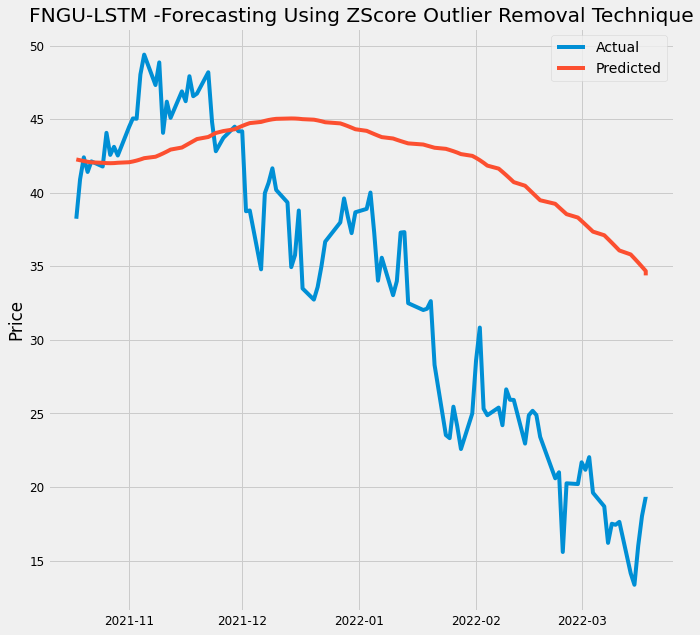

In [151]:
result_metrics_forecast(z_out_actual,z_out_pred,'FNGU-LSTM','ZScore')